In [1]:
%matplotlib notebook
from __future__ import print_function, division
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import scipy.stats as st
import warnings
import time
from IPython import display

# Dear numpy, Please don't tell me about your feelings.
warnings.filterwarnings('ignore', r'covariance is not positive-semidefinite.')

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# GP inference with different kernels

In this notebook, we see how modifying the kernel we use in a GP prior implicitly allows us to do inference over very rich and structured classes of functions. All the visualizations here use almost the same code, with the only difference being that the kernel function is changed each time.

### Utility functions

In [2]:
# given a mean and kernel for the prior, as well as some observed xs and ys
# and some newxs of interest, return the posterior mean and covariance of the
# vector of f applied to the new xs
def posterior(xs, ys, newxs, kernel, sigma2, mean=(lambda g:np.zeros(len(g)))):
    Kold = kernel(xs, xs)
    Koldnew = kernel(xs, newxs)
    Knewold = Koldnew.T
    Knew = kernel(newxs, newxs)
    A = np.linalg.inv(Kold + sigma2*np.eye(len(Kold)))
    return mean(newxs) + Knewold.dot(A.dot(ys-mean(xs))), (Knew - Knewold.dot(A.dot(Koldnew)))

# draw a sample from the posterior implied by the function above
def posterior_sample(xs, ys, newxs, kernel, sigma2, mean=(lambda g:np.zeros(len(g)))):
    mean, cov = posterior(xs, ys, newxs, kernel, sigma2)
    return np.random.multivariate_normal(mean, cov)

# plot many samples from the posterior conditioned on some data, together with the data
# and some marginal variances
def plot_GP_with_obs(kernel, sigma2, fig, functions_ax, grid, num_samples, observations=[], final_shade=False):
    # for shade if needed
    mean, cov = posterior(observations[0], observations[1], grid, kernel, sigma2)
    sd = 2*np.sqrt(np.diagonal(cov))

    def clear_and_plot_points_and_shade():
        plt.cla()
        functions_ax.set_ylim((-1,1))
        functions_ax.set_xlim((-1,1))
        functions_ax.scatter(observations[0], observations[1])
        functions_ax.fill_between(grid, mean - sd, mean + sd, alpha = .3, color='k')
        
    for i in range(num_samples):
        clear_and_plot_points_and_shade()
        ys = posterior_sample(observations[0], observations[1], grid, kernel, sigma2)
        functions_ax.plot(grid, ys, color='b', alpha=0.8)
        fig.canvas.draw()
        
    if final_shade:
        clear_and_plot_points_and_shade()
    fig.canvas.draw()

# iteratively add data points, plotting samples from the updated posterior all the while
def do_GP_inference(observations, k, sigma2, gridsize=101, num_samples=50):
    plt.close() # close existing figure if there was one
    grid = np.linspace(-1,1,gridsize)
    fig = plt.figure(figsize=(10,5))

    # create axis for function sampling
    functions_ax = plt.axes([0.1,0.15,0.8,0.8])

    for i in range(len(observations[0])+1):
        plot_GP_with_obs(k, sigma2, fig, functions_ax, grid, num_samples=num_samples,
                         observations=[observations[0][:i], observations[1][:i]])
    plot_GP_with_obs(k, sigma2, fig, functions_ax, grid, num_samples=0,
                 observations=[observations[0][:i], observations[1][:i]], final_shade=True)

### Kernel definitions
This is where we define the four kernels that we'll be using in the notebook.

In [3]:
# this function just takes a kernel function and makes it into a function that can apply itself
# to all pairs of points in two input vectors
def vectorize(k):
    def f(xs1, xs2):
        return np.array([[k(xs1[i], xs2[j]) for j in range(len(xs2))] for i in range(len(xs1))])
    return f

# a linear kernel
def linear(tau2):
    return vectorize(lambda x1, x2: tau2*(x1*x2 + 1))

# a quadratic kernel
def quad(tau2):
    return vectorize(lambda x1, x2: tau2*(x1*x2 + x1**2 * x2**2 + 1))

# the RBF kernel
def rbf(c,l):
    return vectorize(lambda x1, x2: c * np.exp(-.5 * ((x1 - x2) / l)**2))

# a kernel that describes periodic behavior
def periodic(c,p,l):
    return vectorize(lambda x1, x2: c*np.exp(-2*np.sin(np.pi*np.abs(x1-x2)/p)**2/l**2))

## Fitting data
We now fit data with each of these kernels in turn. Here the hyperparameters of the kernels were chosen to make the demos fun and illustrative. In practice, these are often chosing by maximizing the marginal likelihood of the data.

Suggestion: try fiddling with the various parameters here to see how they affect the resulting inference.

### Linear kernel

<IPython.core.display.Javascript object>


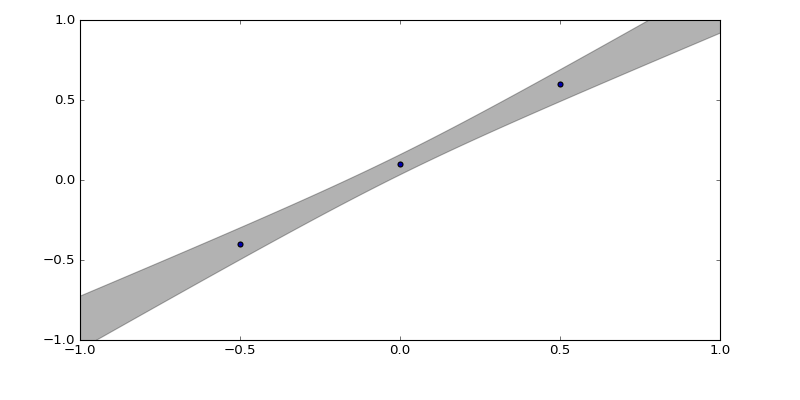

In [4]:
observations = [[0.5, -0.5, 0],
                [0.6, -0.4, 0.1]]
do_GP_inference(observations, linear(0.5), 0.003)

### Quadratic kernel

<IPython.core.display.Javascript object>


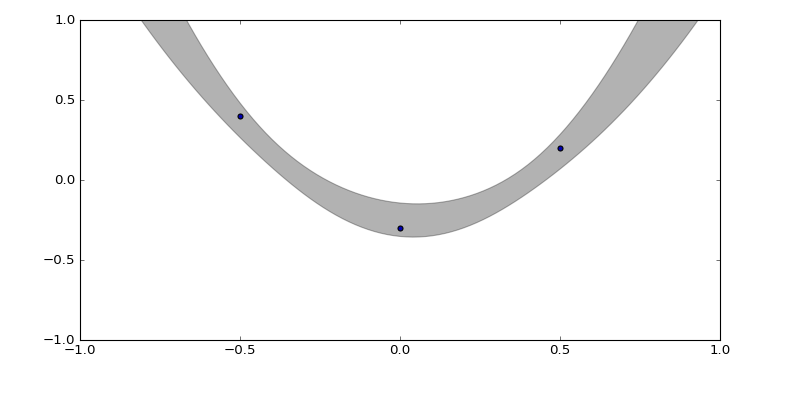

In [5]:
observations = [[0.5, -0.5, 0],
                [0.2,   0.4, -0.3]]
do_GP_inference(observations, quad(0.5), 0.003)

### Squared-exponential (RBF) kernel
Question: the so called "kernel bandwidth" of the RBF kernel is the second parameter passed to the rbf function. What do you think should happen to the posterior if you make the kernel bandwidth smaller or larger? Make a guess and then try it and see.

<IPython.core.display.Javascript object>


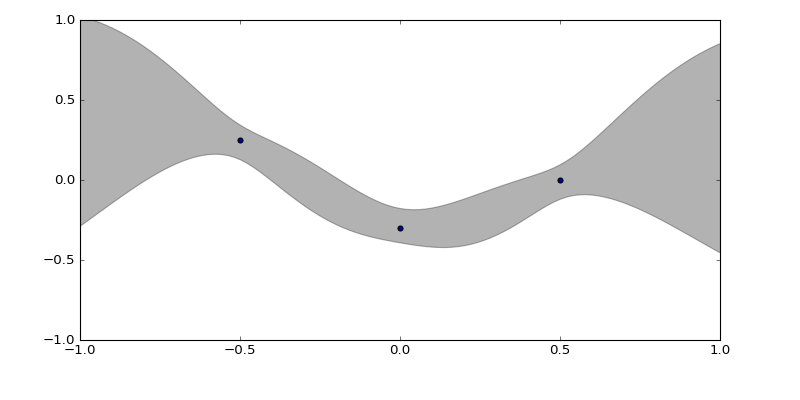

In [6]:
observations = [[0.5, -0.5, 0],
                [0,   0.25, -0.3]]
do_GP_inference(observations, rbf(0.2,0.5), 0.003)

### Periodic kernel
Like with the RBF kernel, different hyperparameters here lead to different behavior. Try playing with the second parameter (which controls the wavelength of the kernel) as well as the third parameter (which controls how smooth one period of the function has to be).

<IPython.core.display.Javascript object>


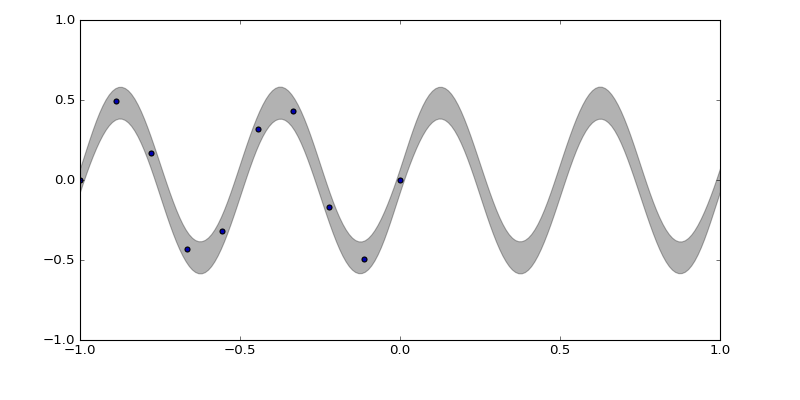

In [7]:
xs = np.linspace(-1,0,10); np.random.shuffle(xs)
ys = 0.5*np.sin(2*xs*2*np.pi)
do_GP_inference([xs,ys], periodic(0.2,1,1), 0.003, gridsize=201, num_samples=2)